In [2]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import tslearn.clustering as tsc

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, Normalizer

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from tslearn.barycenters import softdtw_barycenter 
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances_argmin_min
from sklearn_extra.cluster import KMedoids 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage,  single, complete, average, ward, fcluster
from tslearn.metrics import dtw, cdist_dtw
import importlib
import clustering_processing2, preprocessing, cluster_grid

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

In [ ]:
# Create scaled combined dataframe with time stamps as rows and site IDs as columns
importlib.reload(preprocessing)
from preprocessing import create_combined_df

# create combined_df
# Directory containing the household CSV files
data_dir = cleaned_data_directory

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

combined_df = create_combined_df(cleaned_data_directory, date_range)
# Define the path for the CSV file
csv_path = os.path.join(base_directory, 'combined_aircon_profiles.csv')

# # Write to CSV only if the file doesn't already exist
if not os.path.exists(csv_path):
    combined_df.to_csv(csv_path, index=False)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')



File already exists!


In [ ]:
# Visualize the maximum half-hourly consumption for each household
importlib.reload(preprocessing)
preprocessing.visualize_max_half_hourly_consumption(combined_df)

In [4]:
# Pre-bin the "baseline" group with inputted thresholds for low consumption and create the dictionary for low consumption values.
importlib.reload(preprocessing)
min_cons = 0.02 # pick a number to group low consumption values together, guessing using 10kW air conditioning unit and 50 W standby power consumption
fluctu_ratio = 1.2 # pick a number to group low consumption values together
low_consumption_dict = preprocessing.create_low_consumption_dict(combined_df, min_cons=min_cons)
#low_consumption_dict = preprocessing.create_low_consumption_with_ratio_dict(combined_df, max_threshold=min_cons, fluctuation_ratio_threshold=fluctu_ratio)

In [5]:
print(low_consumption_dict)

{datetime.date(2023, 1, 1): ['S0024', 'S0089', 'S0111', 'S0177', 'S0199', 'S0225', 'S0238', 'S0249', 'S0250', 'S0301', 'S0318', 'S0339', 'S0349', 'S0353', 'S0376', 'S0387', 'S0410', 'S0444', 'S0462', 'S0463', 'S0470', 'S0482', 'S0483', 'S0495', 'S0548', 'S0562', 'W0001', 'W0004', 'W0005', 'W0008', 'W0013', 'W0016', 'W0019', 'W0029', 'W0031', 'W0035', 'W0037', 'W0046', 'W0049', 'W0051', 'W0056', 'W0058', 'W0062', 'W0068', 'W0070', 'W0073', 'W0074', 'W0075', 'W0078', 'W0081', 'W0087', 'W0089', 'W0092', 'W0094', 'W0114', 'W0118', 'W0124', 'W0130', 'W0141', 'W0142', 'W0143', 'W0145', 'W0155', 'W0158', 'W0166', 'W0178', 'W0182', 'W0190', 'W0193', 'W0195', 'W0219', 'W0220', 'W0221', 'W0232', 'W0233', 'W0240', 'W0253', 'W0254', 'W0271', 'W0272', 'W0275', 'W0278', 'W0283', 'W0291', 'W0303', 'W0304', 'W0318', 'W0322', 'W0329', 'W0334', 'W0342'], datetime.date(2023, 1, 2): ['S0024', 'S0083', 'S0089', 'S0110', 'S0111', 'S0159', 'S0173', 'S0177', 'S0199', 'S0216', 'S0225', 'S0238', 'S0249', 'S0250

In [32]:
# Create daily clusters with summary statistics and raw profiles as features 
importlib.reload(cluster_grid)
start_date = '2023-01-01'
end_date = '2023-12-31'
num_clusters = 9
min_cluster_size = None
max_cluster_size = None

# Example usage
rlp_dict, cluster_sites_df, metrics_df = cluster_grid.process_multiple_days(
    df=combined_df,  # Your pre-scaled data
    start_date=start_date,
    end_date=end_date,
    num_clusters=num_clusters,
    low_consumption_sites_dict=low_consumption_dict,
    min_cluster_size=min_cluster_size,  # Optional
    max_cluster_size=max_cluster_size,  # Optional
    feature_weights={  # Optional
        'raw_profile': 0.7,
        'summary_stats': 0.3
    }
)


In [29]:
# create daily clusters with raw profiles as features only 
importlib.reload(cluster_grid)

start_date = '2023-01-01'
end_date = '2023-12-31'
num_clusters = 9
  
rlp_dict, cluster_sites_df, metrics_df = cluster_grid.create_cluster_grid_rep_LP_constrained(combined_df, start_date, end_date, num_clusters, low_consumption_dict, min_cluster_size = None, max_cluster_size=None)


In [ ]:

importlib.reload(cluster_grid)
selected_dates = ['2023-01-01', '2023-01-04', '2023-04-09', '2023-07-12', '2023-12-30']

# Example usage:
fig, axes = cluster_grid.visualize_cluster_grid(rlp_dict, cluster_sites_df, combined_df, num_clusters, selected_dates)
plt.show()

In [19]:
#analyze cluster sizes
importlib.reload(cluster_grid)
# Example usage
result = cluster_grid.analyze_yearly_cluster_sizes(cluster_sites_df)

# Print summary statistics
print("Summary Statistics:")
for stat, value in result['summary_statistics'].items():
    print(f"{stat}: {value}")

Summary Statistics:
average_min_cluster_size: 1.3972602739726028
average_max_cluster_size: 117.65479452054795
total_clusters_with_1_sites: 538
total_clusters_with_2_sites: 470
days_analyzed: 365
total_days_in_year: 365


In [33]:
importlib.reload(cluster_grid)
rlp_aggregated = cluster_grid.aggregate_rlps(rlp_dict)

#Profile_Classes = cluster_grid.create_profile_classes_mean(rlp_aggregated, 9)

In [34]:
# finding the best number of profile classes

importlib.reload(clustering_processing2)
from clustering_processing2 import print_cluster_comparison_report, compare_cluster_sizes, evaluate_clustering_kmeans, mean_index_adequacy, aggregate_rlps, visualize_profile_classes, evaluate_clustering_dtw, evaluate_clustering_kmedoids, evaluate_clustering_kmeans_constrained, evaluate_clustering_kmeans_load_factor, calculate_load_factor

cluster_type = "kmeans"
min_clusters = 7
max_clusters = 8
cluster_results, best_clusters, Profile_Classes = compare_cluster_sizes(rlp_dict, cluster_type, min_clusters, max_clusters, save_plots=False, plot_dir=None, size_max = None)
print_cluster_comparison_report(cluster_results, best_clusters)

Evaluating 7 clusters...
Evaluating 8 clusters...

=== Cluster Comparison Report ===

Metrics Summary:
--------------------------------------------------
   Silhouette Score  Davies-Bouldin Index  Mean Index Adequacy  Combined Index  Silhouette Rank  Davies-Bouldin Rank  MIA Rank  Combined Index Rank
7            0.2473                1.5752               1.2331          7.8556              2.0                  1.0       1.0                  1.0
8            0.2499                1.6602               1.2625          8.3883              1.0                  2.0       2.0                  2.0

Optimal Number of Clusters by Metric:
--------------------------------------------------
Silhouette Score: 8 clusters
Score: 0.2499
Davies-Bouldin Index: 7 clusters
Score: 1.5752
Mean Index Adequacy: 7 clusters
Score: 1.2331
Combined Index: 7 clusters
Score: 7.8556


In [25]:
print(best_clusters['Combined Index'])

7


(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Time of the Day', ylabel='Load'>)

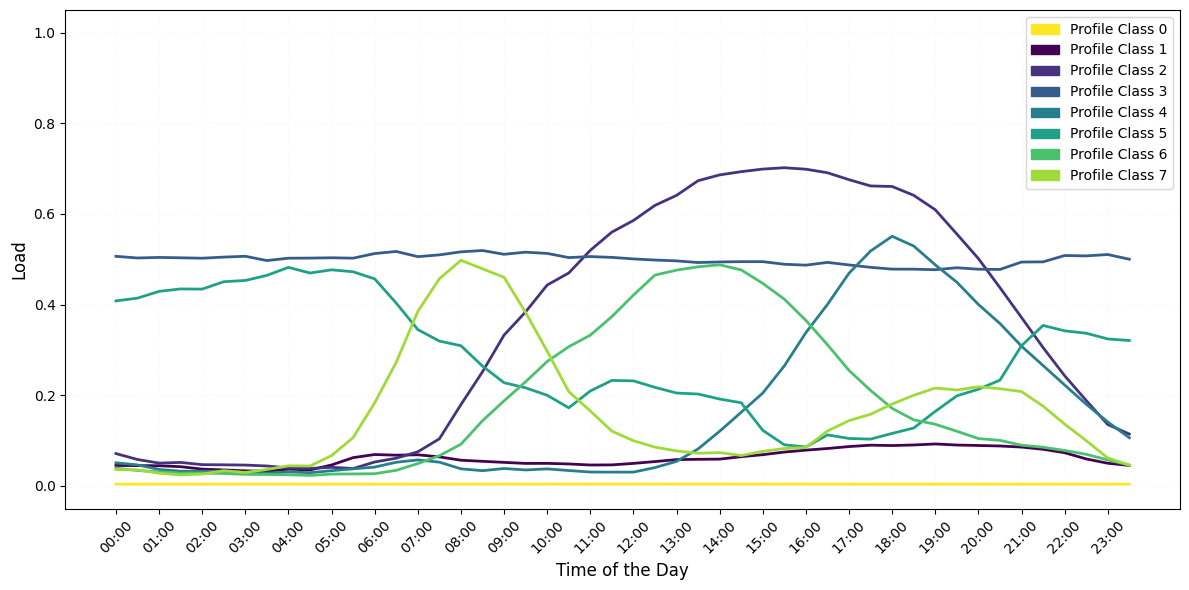

In [26]:
importlib.reload(clustering_processing2)
clustering_processing2.visualize_profile_classes(rlp_aggregated, Profile_Classes, best_clusters['Combined Index'])


Profile Class Sizes:
-------------------
Profile Class 0.0: 365 members
Profile Class 1.0: 1335 members
Profile Class 2.0: 225 members
Profile Class 3.0: 283 members
Profile Class 4.0: 390 members
Profile Class 5.0: 286 members
Profile Class 6.0: 483 members
Profile Class 7.0: 283 members


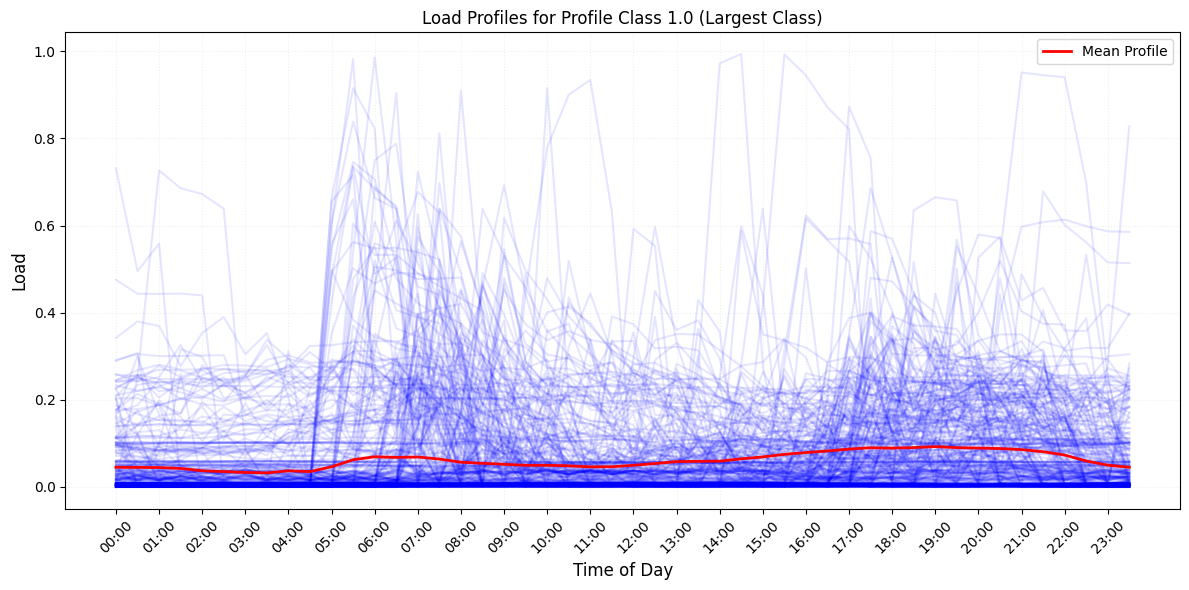

In [27]:
# Usage example:
importlib.reload(clustering_processing2)
class_sizes, fig = clustering_processing2.analyze_profile_classes(rlp_aggregated, Profile_Classes)
plt.show()

In [ ]:
importlib.reload(clustering_processing2)
clustering_processing2.analyze_zero_class(rlp_aggregated, Profile_Classes)

In [76]:
# Merging profile classes and cluster sites dataframes to get final assignments for each site on each day 
Profile_Classes.index.name = 'Date_Cluster' # set index name to match clusters 
date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Merge the two dataframes
merged_df = pd.merge(cluster_sites_df, Profile_Classes.reset_index(), on='Date_Cluster')


# Function to extract date from Date_Cluster
def extract_date(date_cluster):
    return pd.to_datetime(date_cluster.split('_')[0]).date()

merged_df['Date'] = merged_df['Date_Cluster'].apply(extract_date)

merged_df = merged_df.drop(columns = 'Date_Cluster')

# Create the final dataframe
final_df = pd.pivot_table(merged_df, values='Profile_Class', index='Date', columns='site_ID', aggfunc='first')
# Reindex with the full date range
final_df = final_df.reindex(date_range)

for i in final_df.columns:      
    final_df[[i]] = final_df[[i]].astype('Int64')
    
final_df.to_csv(os.path.join(base_directory, 'profile_class_assignments.csv'), index=True)


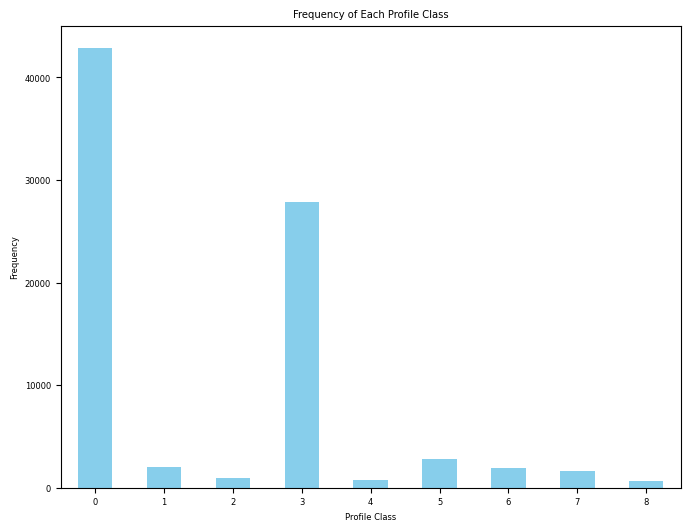

In [77]:
# Create figure of how many observations belong in each profile class 
frequency_counts = final_df.values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Profile Class')
plt.xticks(rotation=0)
plt.show()

In [1]:
plt.figure(figsize=(12, 8))  # Made figure slightly wider

# Create pie chart with more spacing between labels
plt.pie(counts.sort_index(), 
        labels=[f'Class {i}' for i in counts.sort_index().index],
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(counts))})',  # Show both percentage and count on separate lines
        colors=plt.cm.Set3(np.linspace(0, 1, len(counts))),
        startangle=90,
        labeldistance=1.1,    # Move class labels further out
        pctdistance=0.75,     # Move percentage labels closer to center
        radius=0.8)           # Make pie slightly smaller to allow more room for labels

plt.rc('font', size=6)
plt.title('Distribution of Profile Classes', pad=20)  # Add padding to title
plt.axis('equal')
plt.show()

NameError: name 'plt' is not defined

In [ ]:


importlib.reload(clustering_processing2)


survey_df = pd.read_csv(os.path.join(base_directory, 'survey/survey_with_station.csv'))  # Change this to your output directory
survey_df.rename(columns={'edp_site_id': 'site_ID'}, inplace=True)

weather_folder_path = os.path.join(base_directory, 'weather/bom_data_max_min')  # Change this to your output directory
# Run the merger
result_df, incomplete_stations = clustering_processing2.merge_site_weather_data(final_df, survey_df, weather_folder_path)

print(incomplete_stations)

# if it doesn't exist already, export to csv

csv_path = 'df_for_regression_unconverted.csv'
if not os.path.exists(csv_path):
    result_df.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')




Final DataFrame Info:
Shape: (81392, 11)
Missing temperature values:
Max temperature: 0
Min temperature: 0
{}
File written: df_for_regression_unconverted.csv
